In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [137]:
def plot_cumulative_bound(hospital, df, low_cutoff=0, high_cutoff=None, add_vent=True):
    df = df.copy()
    if high_cutoff is None:
        df = df.loc[low_cutoff:]
    else:
        df = df.loc[low_cutoff:high_cutoff]
    
    df['allbeds'] = df['n_occupied_beds(covid)']
    if add_vent:
        df['allbeds'] += df['n_occupied_mv_beds(covid)']
    
    limit_allbeds = [df['allbeds'][low_cutoff]]
    for i in range(1, df['allbeds'].shape[0]):
        limit_allbeds.append(limit_allbeds[-1] + df['n_admits'][i+low_cutoff] + df['n_diagnoses'][i+low_cutoff] - df['n_discharges'][i+low_cutoff])
    df['limit_allbeds'] = np.array(limit_allbeds)

    plt.plot(df.index, df['allbeds'], label='True Number of beds')
    plt.plot(df.index, df['limit_allbeds'], label='Upper bound')
    plt.title(hospital)
    plt.xlabel('Timestep')
    plt.ylabel('Number of beds')
    plt.legend()
    plt.show()

def plot_per_day_bound(hospital, df, low_cutoff=0, high_cutoff=None, add_vent=True):
    df = df.copy()
    if high_cutoff is None:
        df = df.loc[low_cutoff:]
    else:
        df = df.loc[low_cutoff:high_cutoff]
    
    allbeds = np.array(df['n_occupied_beds(covid)'])
    if add_vent:
        allbeds += np.array(df['n_occupied_mv_beds(covid)'])
    
    daily_variation = allbeds[1:] - allbeds[:-1]  
    admitted_minus_discharged = np.array(df['n_admits'] + df['n_diagnoses'] - df['n_discharges'])[1:]
    print(daily_variation[:10])
    print(admitted_minus_discharged[:10])
    
    plt.figure(figsize=(16,6))

#     plt.plot(df.index[1:], daily_variation, label='True Variation in Number of beds')
#     plt.plot(df.index[1:], admitted_minus_discharged, label='Upper bound')
    plt.plot(df.index[1:], admitted_minus_discharged - daily_variation)
    plt.plot(df.index[1:], np.zeros(df.index[1:].shape[0]), ls='--', c='gray')
    plt.title(hospital)
    plt.xlabel('Timestep')
    plt.ylabel('Upper Bound - True Census (must be positive)')
    plt.legend()
    plt.show()

def add_terminals(df):
    df = df.copy()
    
    terminals = [0.0]
    for i in range(1, df['n_occupied_beds(covid)'].shape[0]):
        terminals.append((df['n_admits'][i] + df['n_diagnoses'][i] - df['n_discharges'][i]) - (df['n_occupied_beds(covid)'][i] - df['n_occupied_beds(covid)'][i-1]))
    terminals = np.array(terminals)
    terminals[terminals < 0.0] = 0.0
    df['n_TERMINAL'] = terminals
    
    print(df['n_TERMINAL'].shape)    
    print(df[155:])
    
    plt.figure(figsize=(16,6))
    plt.plot(df.index[1:], df['n_occupied_mv_beds(covid)'][1:], label='vent')
    plt.plot(df.index[1:], df['n_TERMINAL'][1:], label='terminal')
    plt.legend()
    plt.show()
    
    return df

#### General comments

The census counts seem to be one day ahead with respect to the admissions, and perhaps even the discharges.

### Old data (April - July)

In [102]:
# University_Hospitals_Birmingham_NHS_Foundation_Trust
    # bad
# South_Tees_Hospitals_NHS_Foundation_Trust
    # first half not great, second half good
# Chelsea_and_Westminster_Hospital_NHS_Foundation_Trust
    # not too bad if excluding the first 10 days
# Imperial_College_Healthcare_NHS_Trust
    # very up and down...
# King's_College_Hospital_NHS_Foundation_Trust
    # bad
# London_North_West_University_Healthcare_NHS_Trust
    # first half good, second half bad
# Manchester_University_NHS_Foundation_Trust
    # first half ok, second half bad
# Nottingham_University_Hospitals_NHS_Trust
    # first half good if excluding the first 10 days, second half bad
# North_Middlesex_University_Hospital_NHS_Trust (no vent)
    # good!!

hospital = "South_Tees_Hospitals_NHS_Foundation_Trust"
df = pd.read_csv('%s.csv' % hospital)

plot_per_day_bound(hospital, df, low_cutoff=0, high_cutoff=None, vent=False)

plot_cumulative_bound(hospital, df, low_cutoff=0, high_cutoff=None, vent=True)
plot_cumulative_bound(hospital, df, low_cutoff=0, high_cutoff=75, vent=True)
plot_cumulative_bound(hospital, df, low_cutoff=75, high_cutoff=None, vent=True)

TypeError: plot_per_day_bound() got an unexpected keyword argument 'vent'

### New data (September - December)

Idea: use sep-oct as training, nov as testing (September 3rd + 60 days for training, then 30 days for testing). Curve was going up and then flattening during this period, so it is an interesting and practical time frame

Admissions and diagnoses do not seem to be lagged. I suspect that in the later publications they took off the lag.

(266,)
        dates  n_admits  n_discharges  n_occupied_beds(covid)  \
155  4-Sep-20       1.0           2.0                    22.0   
156  5-Sep-20       1.0           0.0                    24.0   
157  6-Sep-20       0.0           0.0                    26.0   
158  7-Sep-20       2.0           2.0                    28.0   
159  8-Sep-20       1.0           2.0                    29.0   
..        ...       ...           ...                     ...   
261       NaN       NaN           NaN                     NaN   
262       NaN       NaN           NaN                     NaN   
263       NaN       NaN           NaN                     NaN   
264       NaN       NaN           NaN                     NaN   
265       NaN       NaN           NaN                     NaN   

     n_occupied_mv_beds(covid)  n_diagnoses  Unnamed: 6  Unnamed: 7  \
155                        2.0          1.0         2.0         NaN   
156                        1.0          1.0         2.0         NaN   

<ipython-input-137-0ef8d75dd509>:60: RuntimeWarning: invalid value encountered in less
  terminals[terminals < 0.0] = 0.0


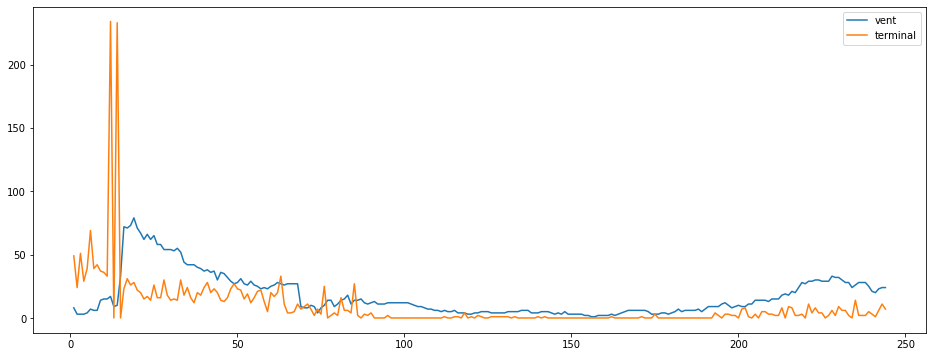

No handles with labels found to put in legend.


[ 2.  2.  2.  1. -2.  0.  5.  4.  8.  1.]
[ 2.  2.  2.  1. -2.  0.  6.  4.  8.  1.]


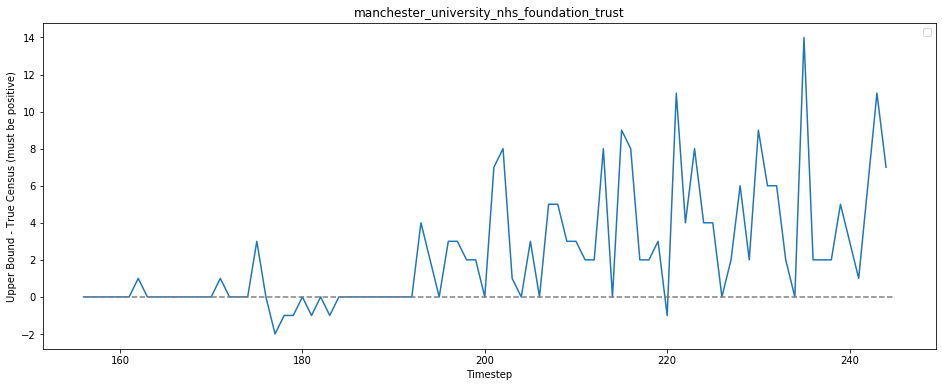

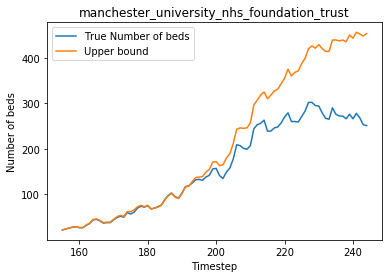

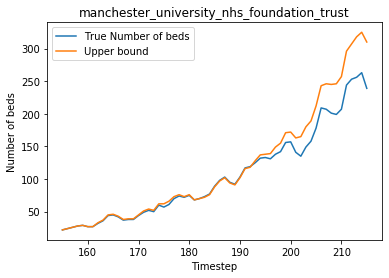

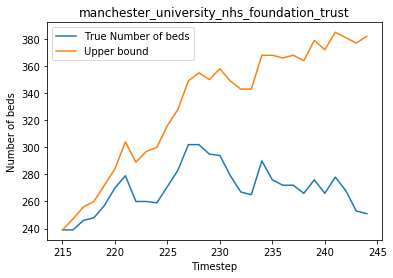

In [141]:
###### with diagnoses

# barts_health_nhs_trust
    # bad
# chelsea_and_westminster_hospital_nhs_foundation_trust
    # not great in the first month
# imperial_college_healthcare_nhs_trust
    # bad
# london_north_west_university_healthcare_nhs_trust (no vent), start at 169
    # good, a couple of outliers that I deleted
# manchester_university_nhs_foundation_trust, start at 156
    # good
# mid_and_south_essex_nhs_foundation_trust, start at 156
    # not great for training (up and down, no deaths), good for testing
# nottingham_university_hospitals_nhs_trust, start at 156
    # bad for training, good for testing
# south_tees_hospitals_nhs_foundation_trust, start at 155
    # great!!
# university_hospitals_birmingham_nhs_foundation_trust, start at 156
    # great!! a couple of outliers that I deleted
# university_hospitals_of_north_midlands_nhs_trust, start at 156
    # good. a few outliers that I deleted. inconsistent in the first ~20 days though
    
hospital = "manchester_university_nhs_foundation_trust"
df = pd.read_csv('new_data/%s.csv' % hospital)

df = add_terminals(df)
df.to_csv('new_data/%s.csv' % hospital)

start = 155

plot_per_day_bound(hospital, df, low_cutoff=start, high_cutoff=start+90, add_vent=False)

plot_cumulative_bound(hospital, df, low_cutoff=start, high_cutoff=start+90, add_vent=False)
plot_cumulative_bound(hospital, df, low_cutoff=start, high_cutoff=start+60, add_vent=False)
plot_cumulative_bound(hospital, df, low_cutoff=start+60, high_cutoff=start+90, add_vent=False)

# plot_per_day_bound(hospital, df, low_cutoff=0, high_cutoff=150, vent=False)

# plot_cumulative_bound(hospital, df, low_cutoff=0, high_cutoff=150, vent=True)
# plot_cumulative_bound(hospital, df, low_cutoff=0, high_cutoff=75, vent=True)
# plot_cumulative_bound(hospital, df, low_cutoff=75, high_cutoff=150, vent=True)